In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster

In [48]:
airports = pd.read_csv('airports.dat.txt', header=None, names=['Airport ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude', 'Altitude', 'Timezone', 'DST', 'Tz database time zone', 'Type', 'Source'])
routes = pd.read_csv('routes.dat.txt', header=None, names=['Airline', 'Airline ID', 'Source airport', 'Source airport ID', 'Destination airport', 'Destination airport ID', 'Codeshare', 'Stops', 'Equipment'])
airlines = pd.read_csv('airlines.dat.txt', header=None, names=['Airline ID', 'Name', 'Alias', 'IATA', 'ICAO', 'Callsign', 'Country', 'Active'])

airports

,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database time zone,Type,Source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7693,14106,Rogachyovo Air Base,Belaya,Russia,\N,ULDA,71.616699,52.478298,272,\N,\N,\N,airport,OurAirports
7694,14107,Ulan-Ude East Airport,Ulan Ude,Russia,\N,XIUW,51.849998,107.737999,1670,\N,\N,\N,airport,OurAirports
7695,14108,Krechevitsy Air Base,Novgorod,Russia,\N,ULLK,58.625000,31.385000,85,\N,\N,\N,airport,OurAirports
7696,14109,Desierto de Atacama Airport,Copiapo,Chile,CPO,SCAT,-27.261200,-70.779198,670,\N,\N,\N,airport,OurAirports


In [49]:
# Check for empty values in the airline dataframe
print("Empty values in airports:")
print(airports.isnull().sum())

# Check for empty values in the airline dataframe
print("\nEmpty values in airlines:")
print(airlines.isnull().sum())

# Check for empty values in the routes dataframe
print("\nEmpty values in routes:")
print(routes.isnull().sum())

Empty values in airports:
Airport ID                0
Name                      0
City                     49
Country                   0
IATA                      0
ICAO                      0
Latitude                  0
Longitude                 0
Altitude                  0
Timezone                  0
DST                       0
Tz database time zone     0
Type                      0
Source                    0
dtype: int64

Empty values in airlines:
Airline ID       0
Name             0
Alias          506
IATA          4627
ICAO            87
Callsign       808
Country         15
Active           0
dtype: int64

Empty values in routes:
Airline                       0
Airline ID                    0
Source airport                0
Source airport ID             0
Destination airport           0
Destination airport ID        0
Codeshare                 53066
Stops                         0
Equipment                    18
dtype: int64


In [50]:
# Replace empty or NaN values with np.nan
airports.replace('', np.nan, inplace=True)
# Drop any rows with at least one NaN value
airports.dropna(inplace=True)

# Replace empty or NaN values with np.nan
airlines.replace('', np.nan, inplace=True)
# Drop the 'Alias' column as it has a high number of missing values
airlines.drop(columns=['Alias'], inplace=True)
# Drop any rows with at least one NaN value
airlines.dropna(inplace=True)

# Replace empty or NaN values with np.nan
routes.replace('', np.nan, inplace=True)
# Drop the 'Codeshare' column as it has a high number of missing values
routes.drop(columns=['Codeshare'], inplace=True)
# Drop any rows with at least one NaN value
routes.dropna(inplace=True)

In [51]:
# Show updated dataframes
print('Airports:\n', airports.head())
print('\nAirlines:\n', airlines.head())
print('\nRoutes:\n', routes.head())

Airports:
    Airport ID                                         Name          City  \
0           1                               Goroka Airport        Goroka   
1           2                               Madang Airport        Madang   
2           3                 Mount Hagen Kagamuga Airport   Mount Hagen   
3           4                               Nadzab Airport        Nadzab   
4           5  Port Moresby Jacksons International Airport  Port Moresby   

            Country IATA  ICAO  Latitude   Longitude  Altitude Timezone DST  \
0  Papua New Guinea  GKA  AYGA -6.081690  145.391998      5282       10   U   
1  Papua New Guinea  MAG  AYMD -5.207080  145.789001        20       10   U   
2  Papua New Guinea  HGU  AYMH -5.826790  144.296005      5388       10   U   
3  Papua New Guinea  LAE  AYNZ -6.569803  146.725977       239       10   U   
4  Papua New Guinea  POM  AYPY -9.443380  147.220001       146       10   U   

  Tz database time zone     Type       Source  
0  Pacifi

Airports dataframe info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7649 entries, 0 to 7697
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Airport ID             7649 non-null   int64  
 1   Name                   7649 non-null   object 
 2   City                   7649 non-null   object 
 3   Country                7649 non-null   object 
 4   IATA                   7649 non-null   object 
 5   ICAO                   7649 non-null   object 
 6   Latitude               7649 non-null   float64
 7   Longitude              7649 non-null   float64
 8   Altitude               7649 non-null   int64  
 9   Timezone               7649 non-null   object 
 10  DST                    7649 non-null   object 
 11  Tz database time zone  7649 non-null   object 
 12  Type                   7649 non-null   object 
 13  Source                 7649 non-null   object 
dtypes: float64(2), int64(2), objec

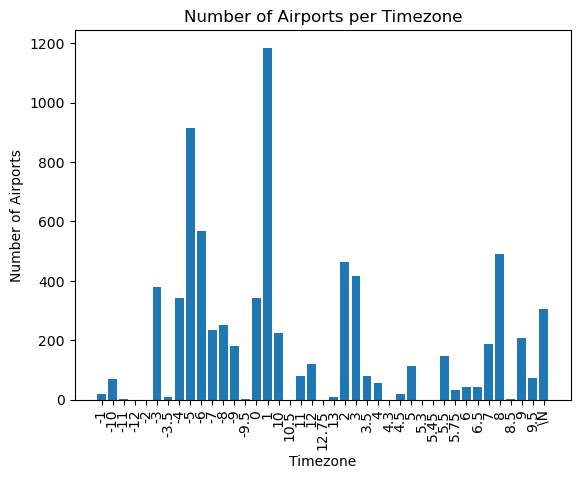

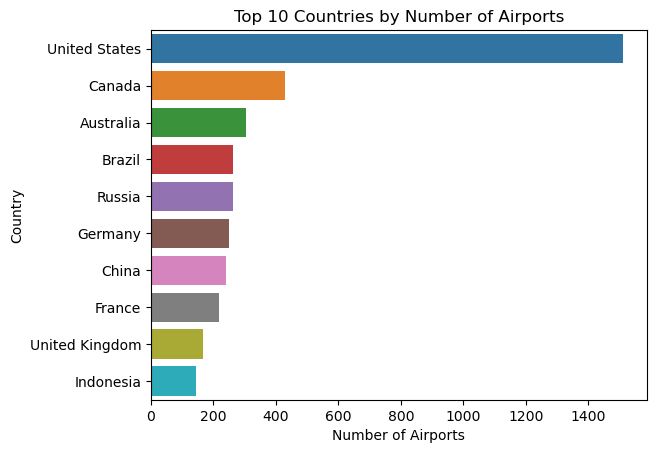

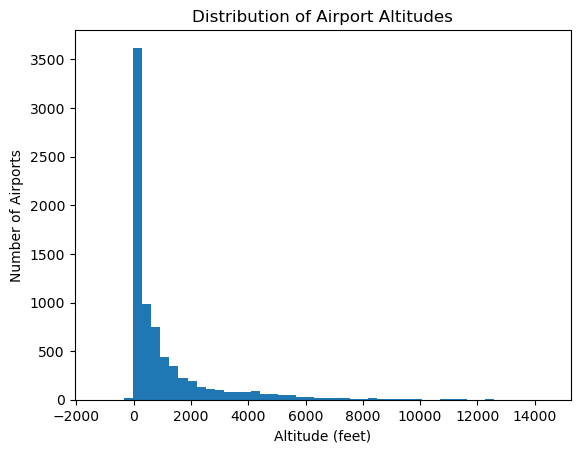

In [52]:
# Explore airports dataframe
print("Airports dataframe info:\n")
print(airports.info())

# Check distribution of timezone values in airports dataframe
timezone_counts = airports["Timezone"].value_counts().sort_index()
plt.bar(timezone_counts.index, timezone_counts.values)
plt.xticks(rotation=90)
plt.xlabel("Timezone")
plt.ylabel("Number of Airports")
plt.title("Number of Airports per Timezone")
plt.show()

# plot number of airports by country
airports_by_country = airports.groupby("Country").size().reset_index(name="Count")
airports_by_country = airports_by_country.sort_values(by="Count", ascending=False).head(10)
sns.barplot(x="Count", y="Country", data=airports_by_country)
plt.title("Top 10 Countries by Number of Airports")
plt.xlabel("Number of Airports")
plt.ylabel("Country")
plt.show()

# Visualize distribution of altitudes in airports dataframe
plt.hist(airports["Altitude"], bins=50)
plt.title("Distribution of Airport Altitudes")
plt.xlabel("Altitude (feet)")
plt.ylabel("Number of Airports")
plt.show()


Airlines dataframe info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1136 entries, 3 to 6161
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Airline ID  1136 non-null   int64 
 1   Name        1136 non-null   object
 2   IATA        1136 non-null   object
 3   ICAO        1136 non-null   object
 4   Callsign    1136 non-null   object
 5   Country     1136 non-null   object
 6   Active      1136 non-null   object
dtypes: int64(1), object(6)
memory usage: 71.0+ KB
None

Number of active vs inactive airlines:

Y    770
N    365
n      1
Name: Active, dtype: int64


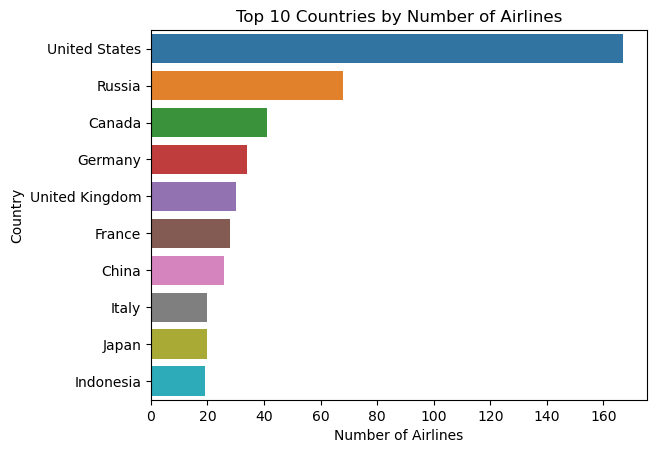

In [53]:
# Explore airlines dataframe
print("\nAirlines dataframe info:\n")
print(airlines.info())

# Check distribution of active vs inactive airlines
print("\nNumber of active vs inactive airlines:\n")
print(airlines["Active"].value_counts())

# plot number of airlines by country
airlines_by_country = airlines.groupby("Country").size().reset_index(name="Count")
airlines_by_country = airlines_by_country.sort_values(by="Count", ascending=False).head(10)
sns.barplot(x="Count", y="Country", data=airlines_by_country)
plt.title("Top 10 Countries by Number of Airlines")
plt.xlabel("Number of Airlines")
plt.ylabel("Country")
plt.show()


Routes dataframe info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67645 entries, 0 to 67662
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Airline                 67645 non-null  object
 1   Airline ID              67645 non-null  object
 2   Source airport          67645 non-null  object
 3   Source airport ID       67645 non-null  object
 4   Destination airport     67645 non-null  object
 5   Destination airport ID  67645 non-null  object
 6   Stops                   67645 non-null  int64 
 7   Equipment               67645 non-null  object
dtypes: int64(1), object(7)
memory usage: 4.6+ MB
None

Number of routes per number of stops:

0    67634
1       11
Name: Stops, dtype: int64


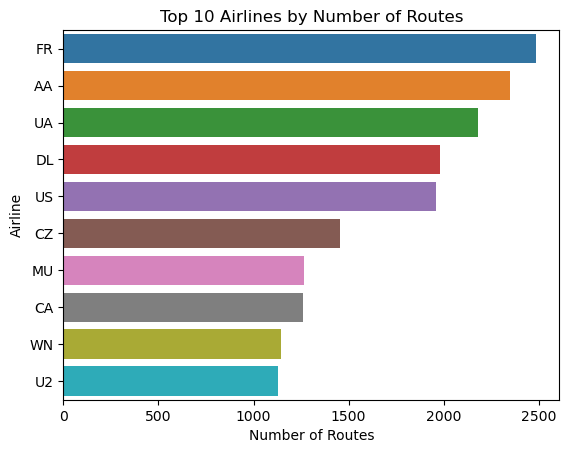

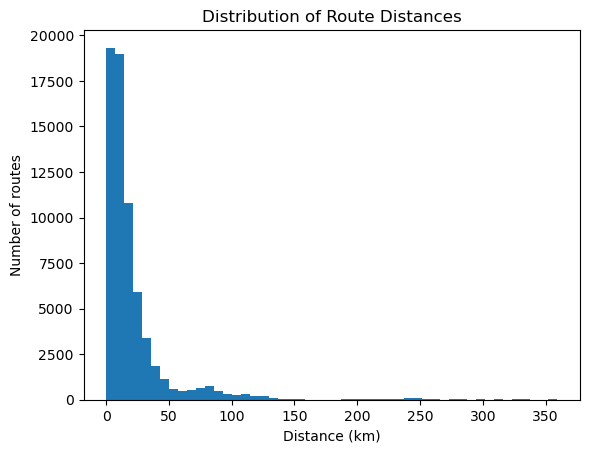

In [54]:
# Explore routes dataframe
print("\nRoutes dataframe info:\n")
print(routes.info())

# Check distribution of number of stops in routes dataframe
print("\nNumber of routes per number of stops:\n")
print(routes["Stops"].value_counts())

# plot number of routes by airline
routes_by_airline = routes.groupby("Airline").size().reset_index(name="Count")
routes_by_airline = routes_by_airline.sort_values(by="Count", ascending=False).head(10)
sns.barplot(x="Count", y="Airline", data=routes_by_airline)
plt.title("Top 10 Airlines by Number of Routes")
plt.xlabel("Number of Routes")
plt.ylabel("Airline")
plt.show()

# merge airport dataframes to get latitude and longitude for source and destination airports
routes_merged = pd.merge(routes, airports[["IATA", "Latitude", "Longitude"]], left_on="Source airport", right_on="IATA", how="left")
routes_merged.rename(columns={"Latitude": "Source Airport Latitude", "Longitude": "Source Airport Longitude"}, inplace=True)
routes_merged.drop(columns=["IATA"], inplace=True)
routes_merged = pd.merge(routes_merged, airports[["IATA", "Latitude", "Longitude"]], left_on="Destination airport", right_on="IATA", how="left")
routes_merged.rename(columns={"Latitude": "Destination Airport Latitude", "Longitude": "Destination Airport Longitude"}, inplace=True)
routes_merged.drop(columns=["IATA"], inplace=True)

# calculate distance between source and destination airports using latitude and longitude
distances = np.sqrt((routes_merged["Source Airport Latitude"] - routes_merged["Destination Airport Latitude"]) ** 2 +
                    (routes_merged["Source Airport Longitude"] - routes_merged["Destination Airport Longitude"]) ** 2)

# add distances as a new column in the routes dataframe
routes_merged["Distance"] = distances

# create histogram of route distances
plt.hist(routes_merged["Distance"], bins=50)
plt.xlabel("Distance (km)")
plt.ylabel("Number of routes")
plt.title("Distribution of Route Distances")
plt.show()

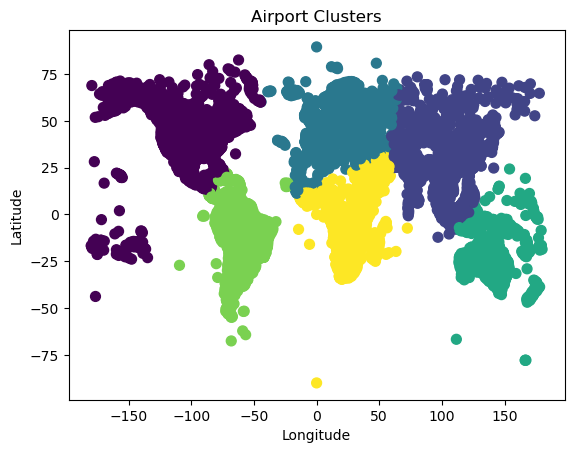

KeyError: "None of [Index(['Source latitude', 'Source longitude', 'Destination latitude',\n       'Destination longitude'],\n      dtype='object')] are in the [columns]"

In [63]:
# Section 1: Clustering airports based on latitude and longitude

# Filter out missing values
airports = airports.dropna(subset=['Latitude', 'Longitude'])

# Define the features to use for clustering
airport_features = ['Latitude', 'Longitude']

# Fit the KMeans model and get the cluster labels
kmeans_airports = KMeans(n_clusters=6, random_state=0).fit(airports[airport_features])
airports['Cluster'] = kmeans_airports.labels_

# Visualize the clusters
plt.scatter(airports['Longitude'], airports['Latitude'], c=airports['Cluster'], s=50)
plt.title('Airport Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Section 2: Clustering airlines based on their country

# Filter out missing values
airlines = airlines.dropna(subset=['Country'])

# Define the features to use for clustering
airline_features = ['Airline ID', 'IATA', 'ICAO', 'Active']
airlines_cluster = airlines.drop(['Name', 'Country'], axis=1)

# Fit the KMeans model and get the cluster labels
kmeans_airlines = KMeans(n_clusters=6, random_state=0).fit(airlines_cluster[airline_features])
airlines['Cluster'] = kmeans_airlines.labels_

# Visualize the clusters
plt.scatter(range(len(airlines)), [0] * len(airlines), c=airlines['Cluster'], s=50)
plt.title('Airline Clusters')
plt.xlabel('Airline')
plt.yticks([])
plt.show()

# Section 3: Clustering routes based on their source and destination airports

# Filter out missing values
routes = routes.dropna(subset=['Source airport', 'Destination airport'])

# Define the features to use for clustering
route_features = ['Source airport', 'Destination airport']

# Fit the KMeans model and get the cluster labels
kmeans_routes = KMeans(n_clusters=3, random_state=0).fit(routes[route_features])
routes['Cluster'] = kmeans_routes.labels_

# Visualize the clusters
plt.scatter(range(len(routes)), [0] * len(routes), c=routes['Cluster'], s=50)
plt.title('Route Clusters')
plt.xlabel('Route')
plt.yticks([])
plt.show()

In [67]:
# Filter out missing values
routes = routes.dropna(subset=['Source airport', 'Destination airport'])

# Merge the airports dataset to obtain the latitude and longitude of each airport
routes = routes.merge(airports[['IATA', 'Latitude', 'Longitude']], how='left', left_on='Source airport', right_on='IATA', suffixes=('_src', '_src_latlon'))
routes = routes.merge(airports[['IATA', 'Latitude', 'Longitude']], how='left', left_on='Destination airport', right_on='IATA', suffixes=('_dst', '_dst_latlon'))

# Define a function to calculate the great-circle distance between two points on Earth
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    d = R * c
    return d

# Calculate the great-circle distance between the source and destination airports for each route
routes['Distance'] = haversine(routes['Source latitude'], routes['Source longitude'], routes['Destination latitude'], routes['Destination longitude'])

# Define the features to use for clustering
route_features = ['Distance']

# Fit the KMeans model and get the cluster labels
kmeans_routes = KMeans(n_clusters=3, random_state=0).fit(routes[route_features])
routes['Cluster'] = kmeans_routes.labels_

# Visualize the clusters
plt.scatter(range(len(routes)), [0] * len(routes), c=routes['Cluster'], s=50)
plt.title('Route Clusters')
plt.xlabel('Route')
plt.yticks([])
plt.show()

C:\Users\Jayam\AppData\Local\Temp\ipykernel_20216\1903387775.py:6: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Latitude_dst', 'IATA_dst', 'Longitude_dst'} in the result is deprecated and will raise a MergeError in a future version.
  routes = routes.merge(airports[['IATA', 'Latitude', 'Longitude']], how='left', left_on='Destination airport', right_on='IATA', suffixes=('_dst', '_dst_latlon'))


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [1]:
data = pd.merge(airports, routes, left_on='IATA', right_on='Source airport')
data = data.dropna(subset=['Country', 'Destination airport'])

features = ['Latitude', 'Longitude']

data['Target'] = np.where(data['Country'] == data['Country'].unique()[0], 'International', 'Domestic')

X_train, X_test, y_train, y_test = train_test_split(data[features], data['Target'], test_size=0.2, random_state=0)

model = DecisionTreeClassifier(max_depth=3, random_state=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy}")

NameError: name 'pd' is not defined

In [ ]:
data = pd.merge(flights, airlines, on='IATA')
data = data.dropna(subset=['DepDelay', 'ArrDelay'])

features = ['Month', 'DayOfWeek', 'CRSDepTime', 'CRSArrTime', 'Distance', 'Airline ID']

X_train, X_test, y_train, y_test = train_test_split(data[features], data['ArrDelay'], test_size=0.2, random_state=0)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")